## import library

In [ ]:
import itertools
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import tensorflow as tf
import tempfile

## mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Bagian Kombinasi


In [ ]:
# Define the paths to your image folders in Google Drive
tops_folder_path = '/content/drive/My Drive/Testing Input Item Image/Top'
bottoms_folder_path = '/content/drive/My Drive/Testing Input Item Image/Bottom'
shoes_folder_path = '/content/drive/My Drive/Testing Input Item Image/Shoes'

In [ ]:
# Function to load and resize images from a folder
def load_and_resize_images(folder_path, target_size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)  # Resize images to a common size
            images.append(img)
    return images

# Function to load images from a folder
def load_images(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            images.append(img)
    return images

# Function to generate outfit combinations
def generate_outfit_combinations(images):
    outfit_combinations = []
    for combination in itertools.product(*images):
        outfit_combinations.append(combination)
    return outfit_combinations

# Function to display outfit combinations
#def display_outfit_combinations_vertical(outfit_combinations):
 #   for i, combination in enumerate(outfit_combinations, 1):
  #      combined_image = np.vstack(combination)  # Stack images vertically
   #     plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
    #    plt.title(f"Outfit {i}")
     #   plt.axis('off')
      #  plt.show()


# Load images from Google Drive folders
tops_images = load_and_resize_images(tops_folder_path)
bottoms_images = load_and_resize_images(bottoms_folder_path)
shoes_images = load_and_resize_images(shoes_folder_path)

# Generate outfit combinations
outfit_combinations = generate_outfit_combinations([tops_images, bottoms_images, shoes_images])

## Display Kombinasi Outfit (OPSIONAL)



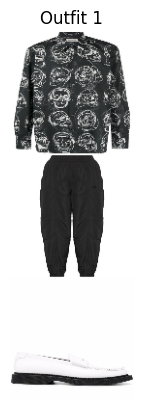

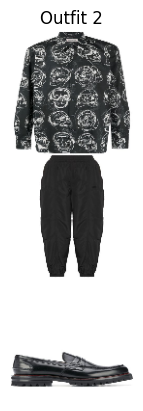

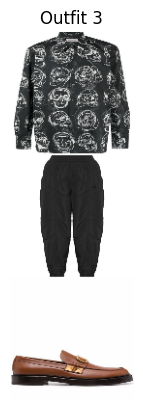

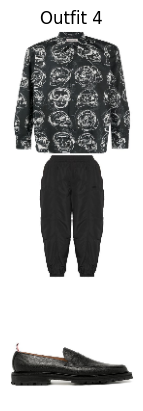

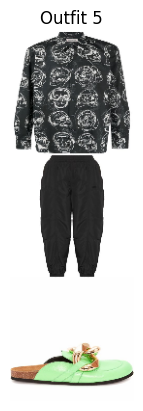

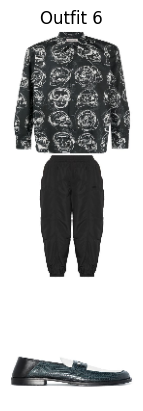

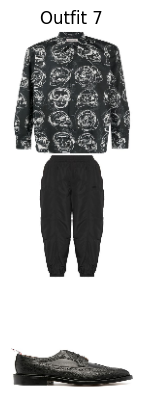

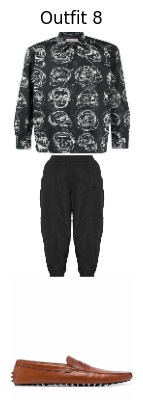

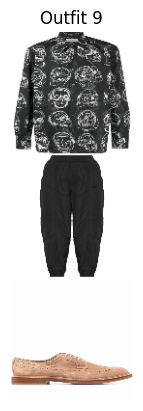

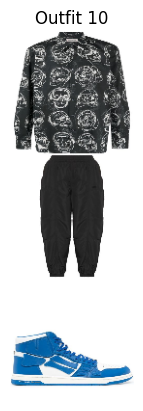

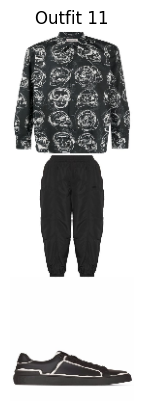

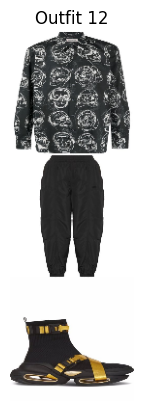

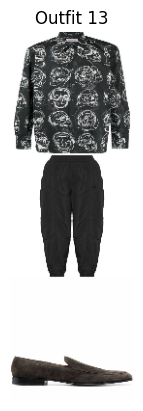

KeyboardInterrupt: ignored

In [ ]:
# Display outfit combinations
#display_outfit_combinations_vertical(outfit_combinations)

# Bagian Memasukkan hasil dari kombinasi ke model CNN

In [ ]:
# Load your TensorFlow Lite model
interpreter = tf.lite.Interpreter(model_path='/content/drive/MyDrive/Capstone/cnn.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def preprocess_image(image_path):
    # Load and preprocess the image
    img = Image.open(image_path).resize((128, 128))
    img = np.array(img) / 255.0  # Normalize if necessary
    return img[np.newaxis, ...].astype(np.float32)  # Add batch dimension



# Dictionary to store image paths and predictions
predictions = {}
#outfit_combinations
for i, combination in enumerate(outfit_combinations, 1):
    # Create a combined image from the outfit combination
    combined_image = np.vstack(combination)  # Stack images vertically

    # Save the combined image to a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix='.jpg') as temp_image_file:
        temp_image_path = temp_image_file.name
        cv2.imwrite(temp_image_path, cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))

    # Call preprocess_image to preprocess the saved image file
    processed_image = preprocess_image(temp_image_path)

    # Set the tensor to point to the input data to be inferred
    interpreter.set_tensor(input_details[0]['index'], processed_image)

    # Run the inference
    interpreter.invoke()

    # Extract the output and store it
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_likes = output_data[0][0]  # Adjust depending on model output format
    predictions[i] = {'likes': predicted_likes, 'outfit': combined_image}



# Now, you can arrange and display the results as needed

# Counter for the number of images displayed
displayed_images_count = 0

# For example, to display images sorted by predicted likes:
for i, result in sorted(predictions.items(), key=lambda x: x[1]['likes'], reverse=True):
  if displayed_images_count < 3:  # Check if less than 3 images have been displayed
    likes = result['likes']
    outfit = result['outfit']

    plt.imshow(cv2.cvtColor(outfit, cv2.COLOR_BGR2RGB))
    plt.title(f"Outfit {i} - Predicted Likes: {likes}")
    plt.axis('off')
    plt.show()

    displayed_images_count += 1  # Increment the counter

  else:
    break  # Exit the loop after displaying 3 images



# Mencoba Implementasi Clustering untuk mencegah muncul outfit yang mirip

In [ ]:
from sklearn.cluster import KMeans

# Dictionary to store image paths and predictions
predictions = {}

# Initialize an empty list to store the predicted likes
predicted_likes_list = []

for i, combination in enumerate(outfit_combinations, 1):
    # Create a combined image from the outfit combination
    combined_image = np.vstack(combination)  # Stack images vertically

    # Call preprocess_image to preprocess the combined image
    processed_image = preprocess_image(temp_image_path)

    # Set the tensor to point to the input data to be inferred
    interpreter.set_tensor(input_details[0]['index'], processed_image)

    # Run the inference
    interpreter.invoke()

    # Extract the output and store it
    output_data = interpreter.get_tensor(output_details[0]['index'])
    predicted_likes = output_data[0][0]  # Adjust depending on model output format
    predictions[i] = {'likes': predicted_likes, 'outfit': combined_image}

    # Append predicted likes to the list
    predicted_likes_list.append(predicted_likes)

# Convert the predicted likes list to a numpy array for clustering
predicted_likes_array = np.array(predicted_likes_list)

# Reshape the predicted_likes_array to have two dimensions
predicted_likes_array = predicted_likes_array.reshape(-1, 1)

# Perform K-Means clustering (you can adjust the number of clusters as needed)
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(predicted_likes_array)

# Group the outfits based on cluster labels
outfits_clusters = [[] for _ in range(num_clusters)]
for i, cluster_label in enumerate(kmeans.labels_):
    # Append the outfit index (i) to the cluster with label cluster_label
    outfits_clusters[cluster_label].append(i)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-8-f151eb6c5604>:38: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(predicted_likes_array)


Cluster 1 - Top 3 Outfits:


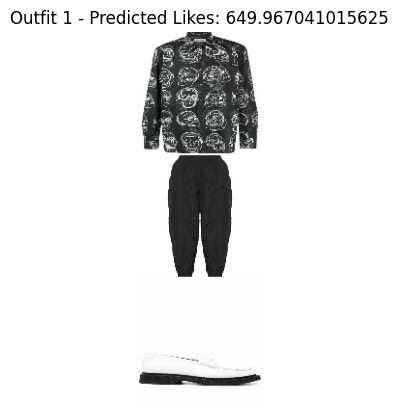

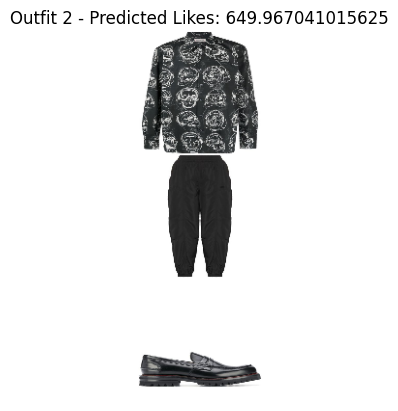

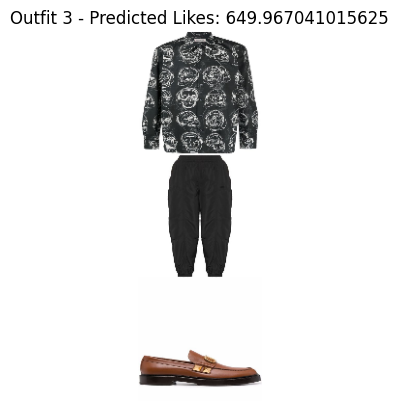

Cluster 2 - Top 3 Outfits:
Cluster 3 - Top 3 Outfits:


In [ ]:
# Display the top 3 outfits with the highest predicted likes in each cluster
for cluster_id, outfit_indices in enumerate(outfits_clusters):
    print(f"Cluster {cluster_id + 1} - Top 3 Outfits:")

    # Sort outfits in the cluster by predicted likes in descending order
    sorted_outfits = sorted(outfit_indices, key=lambda i: -predictions[i + 1]['likes'])

    # Display the top 3 outfits in the cluster
    for i in range(min(3, len(sorted_outfits))):
        outfit_index = sorted_outfits[i]
        likes = predictions[outfit_index + 1]['likes']
        outfit = predictions[outfit_index + 1]['outfit']

        plt.imshow(cv2.cvtColor(outfit, cv2.COLOR_BGR2RGB))
        plt.title(f"Outfit {outfit_index + 1} - Predicted Likes: {likes}")
        plt.axis('off')
        plt.show()


# Display outfits in each cluster

In [ ]:
# Display outfits in each cluster
for cluster_id, outfit_indices in enumerate(outfits_clusters):
    print(f"Cluster {cluster_id + 1}:")
    for outfit_index in outfit_indices:
        likes = predictions[outfit_index + 1]['likes']  # Adjust the key by adding 1
        outfit = predictions[outfit_index + 1]['outfit']  # Adjust the key by adding 1

        plt.imshow(cv2.cvtColor(outfit, cv2.COLOR_BGR2RGB))
        plt.title(f"Outfit {outfit_index + 1} - Predicted Likes: {likes}")
        plt.axis('off')
        plt.show()


Mencoba algoritma DBSCAN (Density-Based Spatial Clustering of Applications with Noise) untuk CLustering

In [ ]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN clustering (adjust parameters as needed)
dbscan = DBSCAN(eps=0.5, min_samples=5).fit(predicted_likes_array)

# Group the outfits based on cluster labels
outfits_clusters = [[] for _ in range(len(set(dbscan.labels_)))]
for i, cluster_label in enumerate(dbscan.labels_):
    if cluster_label != -1:  # Ignore noise points (-1)
        outfits_clusters[cluster_label].append(i)

# Display outfits in each cluster
for cluster_id, outfit_indices in enumerate(outfits_clusters):
    print(f"Cluster {cluster_id + 1}:")
    for outfit_index in outfit_indices:
        likes = predictions[outfit_index + 1]['likes']  # Adjust the key by adding 1
        outfit = predictions[outfit_index + 1]['outfit']  # Adjust the key by adding 1

        plt.imshow(cv2.cvtColor(outfit, cv2.COLOR_BGR2RGB))
        plt.title(f"Outfit {outfit_index + 1} - Predicted Likes: {likes}")
        plt.axis('off')
        plt.show()
